In [30]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [31]:
REBUILD_DATA = False # Set it to true once!!

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

class DogsVsCats():
    imageSize = 50
    cats = "CatsVsDogs/PetImages/Cat"
    dogs = "CatsVsDogs/PetImages/Dog"
    labels = {cats : 0, dogs : 1}
    trainingData = []
    catCount = 0
    dogCount = 0
    
    
    def makeTrainingData(self):
        for label in self.labels:
            print(label)
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label,f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.imageSize, self.imageSize))
                    # np.eye(2).... will produce [0,1] or [1,0]
                    self.trainingData.append([np.array(img), np.eye(2)[self.labels[label]]])
                    # Here we are using hot vectors (like bitmask if second is one it's a dog)
                    if label == self.cats:
                        self.catCount += 1
                    elif label == self.dogs:
                        self.dogCount += 1
                except Exception as e:
                    #print(str(e))
                    pass # if some images are corrupted or not working
        np.random.shuffle(self.trainingData)
        np.save("trainingData.npy", self.trainingData)
        print("Cats:", self.catCount)
        print("Dogs:", self.dogCount)
        
        
if REBUILD_DATA:
    dogsVsCats = DogsVsCats()
    dogsVsCats.makeTrainingData()

Running on the GPU


In [32]:
# Load training data
trainingData = np.load("trainingData.npy", allow_pickle = True)
print(len(trainingData))
print(trainingData[0])

24946
[array([[162, 164, 162, ..., 252, 255, 252],
       [164, 167, 152, ..., 252, 255, 253],
       [167, 171, 156, ..., 252, 255, 252],
       ...,
       [100,  96,  97, ..., 115, 122, 126],
       [100,  97,  95, ..., 131, 104, 130],
       [ 96,  97,  94, ..., 122, 113, 103]], dtype=uint8)
 array([1., 0.])]


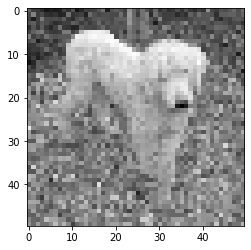

In [33]:
# Let's show a picture
import matplotlib.pyplot as plt

plt.imshow(trainingData[1][0], cmap="gray")
plt.show()


In [34]:
# Our Neural Netowrk Class
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Kernel/Window is 5
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        
        x = torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x) # part of the forward
        
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 2)
        
        
    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)),(2,2))        
        x = F.max_pool2d(F.relu(self.conv3(x)),(2,2))
        
        #print(x[0].shape)
        if self._to_linear is None:
            self._to_linear = x[0].shape[0] * x[0].shape[1] * x[0].shape[2]
            
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear) # To linear ?????
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

In [35]:
net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr = 0.001)
lossFunction = nn.MSELoss()
x = torch.Tensor([i[0] for i in trainingData]).view(-1, 50, 50)
x = x/255.0
y = torch.Tensor([i[1] for i in trainingData])
valPct = 0.1
valSize = int(len(x)*valPct)
print(valSize)

trainX = x[:-valSize]
trainY = y[:-valSize]

testX = x[-valSize:]
testY = y[-valSize:]

print(len(trainX))
print(len(testX))


2494
22452
2494


In [36]:
batchSize = 100
epochs = 3
def train(net):
    optimizer = optim.Adam(net.parameters(), lr = 0.001)
    lossFunction = nn.MSELoss()
    for epoch in range(epochs):
        for i in tqdm(range(0, len(trainX), batchSize)):
            #print(i, i + batchSize)
            batchX = trainX[i:i+batchSize].view(-1,1,50,50)
            batchY = trainY[i:i+batchSize]
            
            batchX, batchY = batchX.to(device), batchY.to(device)
            
            net.zero_grad() # or optimizer.zero_grad because 1 optimizer exists
            outputs = net(batchX)
            loss = lossFunction(outputs, batchY)
            loss.backward()
            optimizer.step()
            
        #print(f"Epoch: {epoch}, Loss: {loss}")
        

In [37]:
def test(net):
    correct = 0
    total = 0

    with torch.no_grad():
        for i in tqdm(range(len(testX))):
            realClass = torch.argmax(testY[i]).to(device) 
            netOut = net(testX[i].view(-1,1,50,50).to(device))[0]
            predictedClass = torch.argmax(netOut)
            if predictedClass == realClass:
                correct += 1
            total += 1
    #print("Accurancy:", round(correct/total,3))

In [38]:
def forwardPass(x, y, train = False):
    if train:
        net.zero_grad()
    outputs = net(x)
    #print("y is :")
   # print(y[0])
    matches = [torch.argmax(i) == torch.argmax(j) for i, j in zip(outputs,y)]
    acc = matches.count(True)/len(matches)
    # there's still code to do here
    loss = lossFunction(outputs, y)
    
    if train:
        loss.backward()
        optimizer.step()
        
    return acc, loss

In [39]:
import numpy as np

def test(size=32):
    randomStart = np.random.randint(len(testX)-size)
    x, y = testX[randomStart:randomStart + size], testY[randomStart:randomStart+size]
    with torch.no_grad():
        valAcc, valLoss = forwardPass(x.view(-1,1,50,50).to(device), y.to(device))
    return valAcc, valLoss

valAcc, valLoss = test(size=32)
#print(valAcc, valLoss)

In [ ]:
import time

modelName = f"model-{int(time.time())}"

net = Net().to(device)

optimizer = optim.Adam(net.parameters(), lr = 0.001)
lossFunction = nn.MSELoss()

#print(modelName)

def train():
    batchSize = 50
    epochs = 5
    with open("model.log", "a") as f:
        for epoch in range(epochs):
            for i in tqdm(range(0, len(trainX), batchSize)):
                batchX = trainX[i:i+batchSize].view(-1,1,50,50).to(device)
                batchY = trainY[i:i+batchSize].to(device)
                
                acc, loss = forwardPass(batchX, batchY, train = True)
                if i % 25 == 0:
                    valAcc, valLoss = test(size=50)
                    #f.write(f"{modelName}.{round(time.time(),3)},{round(float(acc),2)},{round(float(loss),4)},{round(float(valAcc),2)},{round(float(valLoss),4)}\n")
                    
train()
                
                





  0%|                                                                                          | 0/450 [00:00<?, ?it/s]



  0%|▏                                                                                 | 1/450 [00:00<01:00,  7.45it/s]



  0%|▎                                                                                 | 2/450 [00:00<01:00,  7.35it/s]



  1%|▌                                                                                 | 3/450 [00:00<01:00,  7.40it/s]



  1%|▋                                                                                 | 4/450 [00:00<00:59,  7.44it/s]



  1%|▉                                                                                 | 5/450 [00:00<00:59,  7.44it/s]



  1%|█                                                                                 | 6/450 [00:00<00:59,  7.43it/s]



  2%|█▎                                                                                | 7/450 [00:00<00:59,  7.42it/s]



  2%|█▍     